##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [204]:
#%pip install pandas 
#%pip install matplotlib
#%pip install pyarrow
#%pip install seaborn
#%pip install sklearn
#%pip install datetime
# %pip install -U imbalanced-learn

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [205]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.ensemble import (GradientBoostingClassifier)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from imblearn.over_sampling import SMOTE, SMOTENC
from datetime import datetime

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

### 1. Data Exploration

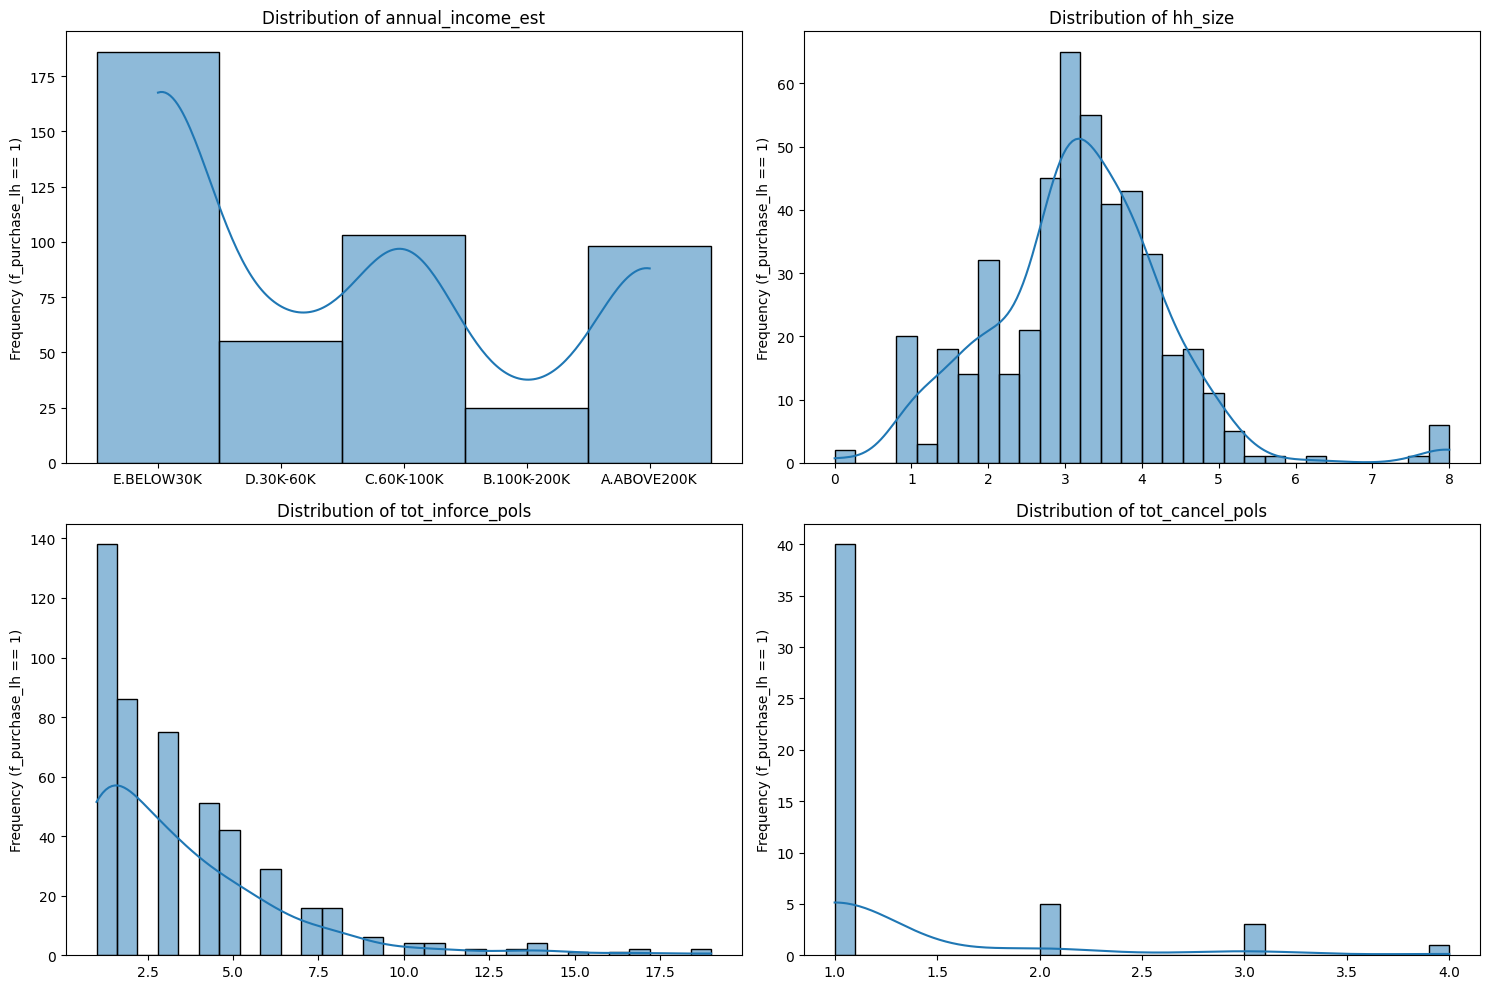

Number of duplicated 'clntnum' values: 0


,% missing
clntnum,0.0
f_hold_gi,0.0
sumins_839f8a,0.0
sumins_e22a6a,0.0
sumins_d0adeb,0.0
...,...
recency_giclaim_unsuccess,100.0
flg_gi_claim_29d435_ever,100.0
flg_gi_claim_058815_ever,100.0
flg_gi_claim_42e115_ever,100.0


In [206]:
filepath = "./data/train_data.parquet" 
df = pd.read_parquet(filepath)
# print(df.dtypes)

def data_exploration_quadrants(dataframe, target_column, continuous_columns):
    """
    Plot distributions of continuous columns in 4 quadrants based on a filtered DataFrame.

    Parameters:
    - dataframe: DataFrame to filter and plot
    - target_column: Target column for filtering
    - continuous_columns: List of continuous columns to plot
    """
    # Filtering the DataFrame based on the target column
    filtered_df = dataframe[dataframe[target_column] == 1].copy()

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    for i, col in enumerate(continuous_columns):
        # Determine the quadrant based on the index
        quadrant = i % 4

        # Sorting categories lexicographically for 'annual_income_est'
        if col == 'annual_income_est':
            sorted_categories = sorted(filtered_df[col].dropna().unique(), reverse=True)
            filtered_df[col] = pd.Categorical(filtered_df[col], categories=sorted_categories, ordered=True)

        # Plotting histograms for continuous columns in the corresponding quadrant
        sns.histplot(filtered_df[col], bins=30, kde=True, ax=axes[quadrant])
        axes[quadrant].set_title(f'Distribution of {col}')
        axes[quadrant].set_xlabel('')
        axes[quadrant].set_ylabel(f'Frequency ({target_column} == 1)')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

continuous_cols = ['annual_income_est', 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols']
data_exploration_quadrants(df, 'f_purchase_lh', continuous_cols)

#flg_latest_being_lapse, flg_latest_being_cancel, tot_inforce_pols do not have missing values
empty_val_check = df[['flg_latest_being_lapse','flg_latest_being_cancel','tot_inforce_pols']]
empty_val_check.isna().sum().sum()

# Check for duplicated rows
duplicated_clntnum_count = df['clntnum'].duplicated(keep=False).sum()
print(f"Number of duplicated 'clntnum' values: {duplicated_clntnum_count}")

# Check for percentages of missing values in each column
missing_vals = df.isna().sum() * 100 / len(df) 
missing_vals.sort_values(inplace=True)

# table of percentages of missing values
missing_vals_df = pd.DataFrame(missing_vals, columns=['% missing'])
missing_vals_df

### 2. Data Cleaning Functions

##### Clean Target Column

In [207]:
def clean_target_column(dataframe, target_column):
    """
    Convert the specified target column to binary (0 or 1), filling missing values with 0.

    Parameters:
    - dataframe: DataFrame to modify
    - target_column: Target column to convert
    """
    dataframe[target_column].fillna(0, inplace=True)
    dataframe[target_column] = dataframe[target_column].astype(int)

    return dataframe

##### Pre-Process Dates and Age

In [208]:
def preprocess_dates_and_age(dataframe):
    """
    Preprocess date columns and calculate length of interaction and age in years.

    Parameters:
    - dataframe: DataFrame to modify
    - min_occ_date_col: Column containing date of interaction
    - cltdob_fix_col: Column containing date of birth

    Returns:
    - Modified DataFrame
    """
    # Convert date columns to datetime
    dataframe['min_occ_date'] = pd.to_datetime(dataframe['min_occ_date'], errors='coerce')
    dataframe['cltdob_fix'] = pd.to_datetime(dataframe['cltdob_fix'], errors='coerce')

    # Calculate length of interaction in days
    dataframe['length_of_interaction'] = (datetime.now() - dataframe['min_occ_date']).dt.days
    dataframe['length_of_interaction'].fillna(dataframe['length_of_interaction'].median(), inplace=True)

    # Calculate age in years
    dataframe['age'] = (datetime.now() - dataframe['cltdob_fix']) / pd.Timedelta(days=365.25)
    dataframe['age'].fillna(dataframe['age'].median(), inplace=True)

    dataframe.drop(columns=['min_occ_date', 'cltdob_fix'], inplace=True)
    
    return dataframe

##### Drop Columns with 100% Missing Values

In [209]:
def drop_column_with_missing_values(dataframe):
    """
    Drop columns with 100% missing values.

    Parameters:
    - dataframe: DataFrame to modify

    Returns:
    - Modified DataFrame
    """
    # Calculate percentages of missing values in each column
    missing_vals = dataframe.isna().sum() * 100 / len(dataframe) 
    missing_vals = missing_vals[missing_vals > 0]
    print(missing_vals[missing_vals == 100])
    dataframe.drop(missing_vals[missing_vals == 100].index, axis=1, inplace=True)

    return dataframe

#### A. General Client Information

In [210]:
def impute_client_info(dataframe):
    """
    Impute missing values for client information.

    Parameters:
    - dataframe: DataFrame to impute

    Returns:
    - DataFrame with imputed values
    """
    clnt_info_columns = ['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clntnum', 'clttype', 'stat_flag']

    for clnt_info_column in clnt_info_columns:
        dataframe[clnt_info_column] = dataframe[clnt_info_column].fillna(dataframe[clnt_info_column].mode()[0])
        dataframe[clnt_info_column] = dataframe[clnt_info_column].astype('category')
    return dataframe

#### B. Client Risk and Status Indicators

In [211]:
def impute_client_risk_status(dataframe):
    """
    Impute missing values for client risk and status indicator columns.

    Parameters:
    - dataframe: DataFrame containing client risk and status indicator columns

    Returns:
    - DataFrame with missing values imputed for specified columns
    """
    # Define client risk and status indicator columns
    clnt_risk_status_columns = [
        'flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
        'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
        'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail'
    ]

    # Impute missing values for each column with its mode
    for clnt_risk_status_column in clnt_risk_status_columns:
        dataframe[clnt_risk_status_column] = dataframe[clnt_risk_status_column].fillna(dataframe[clnt_risk_status_column].mode()[0])
        dataframe[clnt_risk_status_column] = dataframe[clnt_risk_status_column].astype('category')
        
    # Display the count of missing values after imputation
    print(dataframe[clnt_risk_status_columns].isna().sum())

    return dataframe


#### C. Client Consent and Communication Preferences

In [212]:
def impute_client_consent(dataframe):
    """
    Impute missing values for client consent and communication preferences columns.

    Parameters:
    - dataframe: DataFrame containing client consent columns

    Returns:
    - DataFrame with missing values imputed for specified columns
    """
    # Define client consent columns
    clnt_consent_columns = [
        'is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call',
        'is_consent_to_sms', 'is_valid_dm', 'is_valid_email'
    ]

    # Impute missing values for each column with its mode
    for clnt_consent_column in clnt_consent_columns:
        dataframe[clnt_consent_column] = dataframe[clnt_consent_column].fillna(dataframe[clnt_consent_column].mode()[0])
        dataframe[clnt_consent_column] = dataframe[clnt_consent_column].astype('category')

    return dataframe

#### D. Policy and Claim History

In [213]:
def impute_negative_and_recency(dataframe):
    """
    Impute negative values for 'n_months_last_bought_products' and recency-related columns.

    Parameters:
    - dataframe: DataFrame containing relevant columns

    Returns:
    - DataFrame with negative values and missing values imputed for specified columns
    """
    # Impute negative values for 'n_months_last_bought_products'
    median_without_negatives = dataframe['n_months_last_bought_products'][dataframe['n_months_last_bought_products'] >= 0].median()
    dataframe['n_months_last_bought_products'] = dataframe['n_months_last_bought_products'].apply(lambda x: x if x >= 0 else median_without_negatives)

    # Impute 'recency_lapse' with 9999 if 'flg_latest_being_lapse' == 0, otherwise with median
    dataframe.loc[dataframe['flg_latest_being_lapse'] == 0, 'recency_lapse'] = 9999
    dataframe.loc[(dataframe['flg_latest_being_lapse'] == 1) & (dataframe['recency_lapse'].isna()), 'recency_lapse'] = 0

    # Impute 'recency_cancel' with 9999 if 'flg_latest_being_cancel' == 0, otherwise with median
    dataframe.loc[dataframe['flg_latest_being_cancel'] == 0, 'recency_cancel'] = 9999
    dataframe.loc[(dataframe['flg_latest_being_cancel'] == 1) & (dataframe['recency_cancel'].isna()), 'recency_cancel'] = 0

    # Impute missing values of 'tot_cancel_pols'
    dataframe.loc[dataframe['flg_latest_being_cancel'] == 0, 'tot_cancel_pols'] = 0
    dataframe.loc[(dataframe['tot_cancel_pols'].isna()) & (dataframe['flg_latest_being_cancel'] == 1), 'tot_cancel_pols'] = 1

    # Impute missing values of 'f_ever_declined_la'
    dataframe['f_ever_declined_la'].fillna(0, inplace=True)

    return dataframe

#### E. Demographic and Household Information, and Other Flags and Metrics

In [214]:
def impute_demographic_household(dataframe):
    """
    Converting data types, applying mappings, and filling missing values for Demographic and Household Information

    Parameters:
    - dataframe: DataFrame to preprocess

    Returns:
    - Preprocessed DataFrame
    """
    # Convert the data type of 'hh_size_est' to the correct data type
    dataframe['hh_size_est'].replace('>4', 5, inplace=True)
    dataframe['hh_size_est'] = pd.to_numeric(dataframe['hh_size_est'], errors='coerce')

    # Mapping for 'annual_income_est' column
    income_mapping = {
        'A.ABOVE200K': 200001,  
        'B.100K-200K': 150000,  
        'C.60K-100K': 80000,
        'D.30K-60K': 45000,
        'E.BELOW30K': 15000
    }
    # Apply the mapping to the 'annual_income_est' column
    dataframe['annual_income_est'].replace(income_mapping, inplace=True)

    # Fill in missing values with the median for specified columns
    col_names_fill_median = ['hh_20', 'pop_20', 'hh_size', 'hh_size_est', 'annual_income_est']
    for c in col_names_fill_median:
        dataframe[c] = pd.to_numeric(dataframe[c], errors='coerce')
        median_value = dataframe[c].median()
        dataframe[c].fillna(median_value, inplace=True)

    # Fill in missing values with the mode for specified columns
    col_names_fill_mode = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy']
    for c in col_names_fill_mode:
        mode_value = dataframe[c].mode()[0]
        dataframe[c].fillna(mode_value, inplace=True)
        dataframe[c] = dataframe[c].astype('category')

    # Fill in missing values with 0 for specified columns
    col_names_fill_zero = ['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'clmcon_visit_days']
    for c in col_names_fill_zero:
        dataframe[c].fillna(0, inplace=True)
        dataframe[c] = dataframe[c].astype('category')

    # Fill in missing values with 0 for numeric columns
    for c in dataframe.loc[:, 'hlthclaim_amt':]:
        if c not in dataframe.columns or c =='f_purchase_lh':
            continue
        dataframe[c].fillna(0, inplace=True)
        dataframe[c] = dataframe[c].astype(float)

    # Fill in missing values with 9999 for specified columns
    col_names_fill_9999 = ['n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis']
    for c in col_names_fill_9999:
        #if column doesn't exist then continue
        dataframe[c].fillna(9999, inplace=True)
        dataframe[c] = dataframe[c].astype(int)

    dataframe['affcon_visit_days'] = dataframe['affcon_visit_days'].astype(int)
    dataframe['clmcon_visit_days'] = dataframe['clmcon_visit_days'].astype(int)
    return dataframe

#### F. Cleaning Purchase and Lapse Metrics for Specific Products

In [215]:
def fill_missing_lapse_purchase_data(dataframe):
    """
    Fill missing values in lapse and purchase data columns with specified values.

    Parameters:
    - dataframe: DataFrame to fill missing values

    Returns:
    - DataFrame with missing values filled
    """
    # Checking number of empty values in lapse data
    lapse_specific = dataframe.loc[:, 'lapse_ape_ltc_1280bf':'n_months_since_lapse_32c74c']
    lapse_empty_sum = lapse_specific.isna().sum().sum()

    # Fill in missing values with 0 for lapses
    for column in dataframe.loc[:, 'lapse_ape_ltc_1280bf':'lapse_ape_32c74c']:
        dataframe[column] = dataframe[column].fillna(0)

    # Fill in missing values with 9999 for n_months_since_lapse
    for column in dataframe.loc[:, 'n_months_since_lapse_ltc_1280bf':'n_months_since_lapse_32c74c']:
        dataframe[column] = dataframe[column].fillna(9999)

    # Checking number of empty values in purchase data
    purchase_specific = dataframe.loc[:, 'f_ever_bought_839f8a':'n_months_last_bought_32c74c']
    purchase_empty_sum = purchase_specific.isna().sum().sum()

    # Tally number of purchase
    first_set_purchase = dataframe.loc[:, 'f_ever_bought_839f8a':'f_ever_bought_gi']
    sec_set_purchase = dataframe.loc[:, 'f_ever_bought_ltc_1280bf':'f_ever_bought_32c74c']
    combined_purchase_data = pd.concat([first_set_purchase, sec_set_purchase], axis=1)
    dataframe['num_purchase'] = combined_purchase_data.sum(axis=1)



    return dataframe

In [216]:
def convert_data_to_integer(dataframe):
    columns_to_convert = [col for col in dataframe.columns if col.startswith(('ape_', 'sumins_', 'prempaid_','n_months_last_bought_','n_months_since_lapse_','f_purchase_lh', 'lapse_ape_'))]
    for col in columns_to_convert:
        dataframe[col] = dataframe[col].astype(int)
    return dataframe

In [217]:
def convert_data_to_binary(dataframe):
    columns_to_convert = [col for col in dataframe.columns if col.startswith(('cltsex_fix','flg_','is_','f_ever_bought_','f_', 'race_','clttype','stat_flag'))]
    for col in columns_to_convert:
        dataframe[col] = dataframe[col].astype('category')
    return dataframe

#### One-Hot Encoding

In [218]:
def one_hot_encode_categorical(dataframe):
    """
    One-hot encode categorical variables in a DataFrame.

    Parameters:
    - dataframe: DataFrame containing categorical variables

    Returns:
    - DataFrame with one-hot encoded categorical variables
    """
    category_list = ('race_desc','clttype','stat_flag')

    # One-hot encode categorical variables
    for col in category_list:
        dataframe_encoded = pd.get_dummies(dataframe[col], prefix=col)
        dataframe = dataframe.join(dataframe_encoded, lsuffix='_left', rsuffix='_right')

    return dataframe

#### Feature Scaling

In [219]:
def standardise_numerical_features(dataframe):
    """
    Apply standard scaling to numerical features in a DataFrame.

    Parameters:
    - dataframe: DataFrame containing numerical features

    Returns:
    - DataFrame with standardized numerical features
    """
    scaler = StandardScaler()

    # Identify numerical features
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Apply standard scaling to numerical features
    dataframe[numerical_features] = scaler.fit_transform(dataframe[numerical_features])

    return dataframe

##### Overall Data Cleaning Function

In [220]:
# Overall Data Cleaning Function
def clean_data(dataframe):
    # Pre-Processing
    result = dataframe
    result = preprocess_dates_and_age(result)
    result = fill_missing_lapse_purchase_data(result)
    result = drop_column_with_missing_values(result)

    # Imputing
    result = impute_client_info(result)
    result = impute_client_risk_status(result)
    result = impute_client_consent(result)
    result = impute_negative_and_recency(result)
    result = impute_demographic_household(result)

    if 'f_purchase_lh' in result.columns:
        result = clean_target_column(result, 'f_purchase_lh')
    result = convert_data_to_integer(result)
    result = convert_data_to_binary(result)
    result = one_hot_encode_categorical(result)
    result = standardise_numerical_features(result)

    return result

#### Synthethic Minority Oversampling Technique

In [221]:
def balance_data(dataframe):
    X = df.drop(columns=['f_purchase_lh'])
    y = dataframe['f_purchase_lh'].astype(int)
    X.drop(columns=['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clttype', 'stat_flag', 'clntnum'], inplace=True)
    categorical_columns = X.select_dtypes(include=['category']).columns.to_list()
    # Apply SMOTE
    smote = SMOTENC(random_state=42, categorical_features=categorical_columns)
    X_smote, y_smote = smote.fit_resample(X, y)
    return X_smote, y_smote

### 4. Feature Selection

#### A. Filter Method

#### Using Pearson Correlation

In [222]:
df = clean_data(df)
y = df['f_purchase_lh']

giclaim_cnt_success          100.0
recency_giclaim_success      100.0
giclaim_cnt_unsuccess        100.0
recency_giclaim_unsuccess    100.0
flg_gi_claim_29d435_ever     100.0
flg_gi_claim_058815_ever     100.0
flg_gi_claim_42e115_ever     100.0
flg_gi_claim_856320_ever     100.0
dtype: float64
flg_substandard               0
flg_is_borderline_standard    0
flg_is_revised_term           0
flg_is_rental_flat            0
flg_has_health_claim          0
flg_has_life_claim            0
flg_gi_claim                  0
flg_is_proposal               0
flg_with_preauthorisation     0
flg_is_returned_mail          0
dtype: int64


In [223]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
non_numeric_cols = df.select_dtypes(include=["string", "object", "datetime64[ns]"]).columns

In [ ]:
# Point-Biserial Correlation
from scipy.stats import pointbiserialr

# Define Features (X) and Target Variable (y)
X = df.drop('f_purchase_lh', axis=1)  # Features
y = df['f_purchase_lh']  # Target variable

# Ensure all arrays have the same length
correlation_coefficients, p_values, feature_names = [], [], []

for column in X.columns:
    if X[column].dtype in ('float', 'int'):  # Exclude non-numerical columns
        correlation_coefficient, p_value = pointbiserialr(X[column], y)
        correlation_coefficients.append(abs(correlation_coefficient))
        p_values.append(p_value)
        feature_names.append(column)

# Combine results into a DataFrame for easier analysis
correlation_df = pd.DataFrame({
    'Feature': feature_names,
    'Correlation Coefficient': correlation_coefficients,
    'P-Value': p_values
})

# Sort by absolute correlation coefficient in descending order
correlation_df = correlation_df.sort_values(by='Correlation Coefficient', ascending=False)

# Display the correlation results
print("Point-Biserial Correlation Results:")
print(correlation_df.head())

Point-Biserial Correlation Results:
                         Feature  Correlation Coefficient        P-Value
176      n_months_last_bought_gi                 0.191234  5.011311e-104
219                 num_purchase                 0.118646   1.025949e-40
6                  recency_lapse                 0.096993   1.037883e-27
203  n_months_since_visit_affcon                 0.081453   5.426553e-20
170  n_months_last_bought_839f8a                 0.080785   1.086700e-19


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5546: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


#### Using SelectKBest (Mutual Information & Chi-Square)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.drop(columns=['ctrycode_desc', 'cltsex_fix', 'clntnum', 'race_desc','clttype','stat_flag'], inplace=True)

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

numeric_selector = SelectKBest(score_func=mutual_info_classif, k=5)
categorical_selector = SelectKBest(score_func=chi2, k=5)

X_train_numeric_selected = numeric_selector.fit_transform(X_train[numeric_cols], y_train)
X_train_categorical_selected = categorical_selector.fit_transform(X_train[categorical_cols], y_train)

selected_numeric_indices = numeric_selector.get_support(indices=True)
selected_categorical_indices = categorical_selector.get_support(indices=True)

selected_numeric_features = [numeric_cols[i] for i in selected_numeric_indices]
selected_categorical_features = [categorical_cols[i] for i in selected_categorical_indices]

X_train_selected = pd.concat([pd.DataFrame(X_train_numeric_selected), pd.DataFrame(X_train_categorical_selected)], axis=1)

selected_feature_names = selected_numeric_features + selected_categorical_features
X_train_selected.columns = selected_feature_names

print("Selected Numeric Features:")
print(selected_numeric_features)
print("\nSelected Categorical Features:")
print(selected_categorical_features)
print("\nSelected Data:")
print(X_train_selected.head())


Selected Numeric Features:
['n_months_last_bought_products', 'recency_lapse', 'n_months_last_bought_gi', 'n_months_last_bought_grp_70e1dd', 'num_purchase']

Selected Categorical Features:
['flg_gi_claim', 'flg_latest_being_lapse', 'f_ever_bought_gi', 'f_mindef_mha', 'flg_affconnect_ready_to_buy_ever']

Selected Data:
   n_months_last_bought_products  recency_lapse  n_months_last_bought_gi  \
0                          178.0         9999.0                   9999.0   
1                            3.0         9999.0                      3.0   
2                            8.0         9999.0                   9999.0   
3                           10.0         9999.0                   9999.0   
4                            8.0         9999.0                   9999.0   

   n_months_last_bought_grp_70e1dd  num_purchase  flg_gi_claim  \
0                            178.0           3.0           0.0   
1                           9999.0           1.0           1.0   
2                         

### 5. Modelling

#### Support Vector Machine

In [225]:
features = ['n_months_last_bought_products', 'recency_lapse', 'n_months_last_bought_gi', 'n_months_last_bought_grp_70e1dd', 'num_purchase', 'flg_gi_claim', 'flg_latest_being_lapse', 'f_ever_bought_gi', 'f_mindef_mha', 'flg_affconnect_ready_to_buy_ever']

In [226]:
from sklearn.metrics import classification_report
from sklearn.svm import SVC

X_smote, y_smote = balance_data(df)

# Train the model
model = SVC(C=10, gamma=0.001)
model.fit(X_smote[features], y_smote)

SVC(C=10, gamma=0.001)

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [235]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    features = ['n_months_last_bought_products', 'recency_lapse', 'n_months_last_bought_gi', 'n_months_last_bought_grp_70e1dd', 'num_purchase', 'flg_gi_claim', 'flg_latest_being_lapse', 'f_ever_bought_gi', 'f_mindef_mha', 'flg_affconnect_ready_to_buy_ever']
    hidden_data = clean_data(hidden_data)
    # Check for NaN values in each column of X_smote
    for column in hidden_data.columns:
        if hidden_data[column].isnull().any():
            print(f"Column {column} contains NaN values.")

    hidden_data = hidden_data[features]
    result = model.predict(hidden_data)
    return result

##### Cell to check testing_hidden_data function

In [236]:
# This cell should output a list of predictions.
from sklearn.metrics import accuracy_score

test_df = pd.read_parquet('./data/test_data.parquet')

y_test = test_df['f_purchase_lh']
y_test.fillna(0, inplace=True)

test_df = test_df.drop(columns=["f_purchase_lh"])
test_predictions_array = testing_hidden_data(test_df)
print(test_predictions_array)

giclaim_cnt_success          100.0
recency_giclaim_success      100.0
giclaim_cnt_unsuccess        100.0
recency_giclaim_unsuccess    100.0
flg_gi_claim_29d435_ever     100.0
flg_gi_claim_058815_ever     100.0
flg_gi_claim_42e115_ever     100.0
flg_gi_claim_856320_ever     100.0
dtype: float64
flg_substandard               0
flg_is_borderline_standard    0
flg_is_revised_term           0
flg_is_rental_flat            0
flg_has_health_claim          0
flg_has_life_claim            0
flg_gi_claim                  0
flg_is_proposal               0
flg_with_preauthorisation     0
flg_is_returned_mail          0
dtype: int64
[0 0 0 ... 1 0 1]


In [237]:
test_accuracy = accuracy_score(test_predictions_array, y_test)
print(test_predictions_array)
print(test_accuracy)

[0 0 0 ... 1 0 1]
0.8532789922193404


In [238]:
print(classification_report(y_test, test_predictions_array))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92      5169
         1.0       0.14      0.50      0.22       229

    accuracy                           0.85      5398
   macro avg       0.56      0.68      0.57      5398
weighted avg       0.94      0.85      0.89      5398



### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!